# Imports and Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import torch.nn.functional as F
from torch.nn import init
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models

2024-06-26 11:30:14.102718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 11:30:14.102833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 11:30:14.274338: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = "/kaggle/input/autism-paper-data/Retained/dataset_file_directory.csv"
df_original = pd.read_csv(path)
df_original.head()

,Filename,Participant,Label
0,210408_2025_00-01-38.27--00-01-40.84.wav,P01,social
1,210324_2036_00-06-03.61--00-06-05.78.wav,P01,social
2,210324_2036_00-09-04.66--00-09-06.16.wav,P01,social
3,210324_2036_00-11-18.6--00-11-20.3.wav,P01,social
4,200506_2110_00-01-25.92--00-01-26.58c.wav,P01,social


In [3]:
df_original.shape[0]

6450

In [4]:
df_original.Label.unique() #Print unique types of sound

array(['social', 'selftalk', 'request', 'delighted', 'dysregulated',
       'frustrated'], dtype=object)

In [5]:
df_original['Label'].value_counts() 

Label
selftalk        1885
frustrated      1536
delighted       1272
dysregulated     704
social           634
request          419
Name: count, dtype: int64

In [6]:
#Convert Text to number notation for target variable (Categorical to numerical data)

"""
Combine classes to account for class imbalance and to reduce the number of classes: -
self talk - 0
frusturated, protest, no - 1
delighted, laughter, happy, glee, laugh  - 2
dysregulated, dysregulation-sick, dysregulation-bathroom - 3
social, affectionate, greeting - 4
request, help, bathroom, tablet, bathroom - 5
yes, more, hunger - 6
"""

df_original["classID"] = df_original['Label']
df_original['classID'].replace(['selftalk', 'frustrated', 'delighted', 'dysregulated', 'social', 'request'],
                        [0, 1, 2, 3, 4, 5], inplace=True)


#Create new dataframe called 'df' with only two columns - Filename, classID.
df = df_original
df = df.drop(['Participant', 'Label'], axis=1)
df.head()

/tmp/ipykernel_34/4223752362.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_original['classID'].replace(['selftalk', 'frustrated', 'delighted', 'dysregulated', 'social', 'request'],
/tmp/ipykernel_34/4223752362.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_original['classID'].repl

,Filename,classID
0,210408_2025_00-01-38.27--00-01-40.84.wav,4
1,210324_2036_00-06-03.61--00-06-05.78.wav,4
2,210324_2036_00-09-04.66--00-09-06.16.wav,4
3,210324_2036_00-11-18.6--00-11-20.3.wav,4
4,200506_2110_00-01-25.92--00-01-26.58c.wav,4


In [7]:
df['classID'].value_counts() #Number of datapoints available for each target variable

classID
0    1885
1    1536
2    1272
3     704
4     634
5     419
Name: count, dtype: int64

In [8]:
# Construct file path by concatenating fold and file name
df['relative_path'] = '/' + df['Filename'].astype(str)

# Take relevant columns
df = df[['relative_path', 'classID']]
df.head()

,relative_path,classID
0,/210408_2025_00-01-38.27--00-01-40.84.wav,4
1,/210324_2036_00-06-03.61--00-06-05.78.wav,4
2,/210324_2036_00-09-04.66--00-09-06.16.wav,4
3,/210324_2036_00-11-18.6--00-11-20.3.wav,4
4,/200506_2110_00-01-25.92--00-01-26.58c.wav,4


# Audio Pre-processing

In [9]:
#Random shuffle of rows.
df = df. sample(frac=1)
df.head()

,relative_path,classID
5781,/200906_1558_00-04-07.55--00-04-08.23.wav,1
466,/210113_2220_00-02-19.61--00-02-21.08.wav,0
4113,/210216_0944_00-02-43.79--00-02-44.40c.wav,0
2713,/200715_2219_00-21-35.87--00-21-38.57.wav,3
1153,/200321_2039_00-01-24.37--00-01-24.79.wav,2


In [10]:
#Function to read and load the audio files in '.wav' format using Pytorch.
class AudioUtil():
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file) # Load an audio file. Return the signal as a tensor and the sample rate
    return (sig, sr)


#Refer tutotial file for explaination about the following blocks of code: -
  def rechannel(aud, new_channel):
    sig, sr = aud
    if (sig.shape[0] == new_channel):
      return aud
    if (new_channel == 1):
      resig = sig[:1, :]
    else:
      resig = torch.cat([sig, sig])
    return ((resig, sr))

  def resample(aud, newsr):
    sig, sr = aud
    if (sr == newsr):
      return aud
    num_channels = sig.shape[0]
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])
    return ((resig, newsr))

  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms
    if (sig_len > max_len):
      sig = sig[:,:max_len]
    elif (sig_len < max_len):
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))
      sig = torch.cat((pad_begin, sig, pad_end), 1)
    return (sig, sr)

  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
    return aug_spec

In [11]:
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  #Number of items in dataset
  def __len__(self):
    return len(self.df)


  #Get i'th item in dataset
  def __getitem__(self, idx):
    #Absolute file path of the audio file = audio directory + relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    #Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    """
    Some sounds have a higher sample rate, or fewer channels compared to the
    majority. So make all sounds have the same number of channels and same
    sample rate. Unless the sample rate is the same, the pad_trunc will still
    result in arrays of different lengths, even though the sound duration is
    the same.
    """
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)


    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [12]:
data_path = "/kaggle/input/autism-paper-data/Retained/audio"
myds = SoundDS(df, data_path)
#myds = SoundDS(df, path)

#Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

#Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [13]:
print(num_items, num_train, num_val)

6450 5160 1290


In [14]:
type(train_dl)

torch.utils.data.dataloader.DataLoader

# Training VGG19

In [15]:
import torchvision.models as models
model_VGG = models.vgg19_bn(pretrained=True)
model_VGG.features[0] = nn.Conv2d(2, model_VGG.features[0].out_channels,
                               kernel_size=model_VGG.features[0].kernel_size,
                               stride=model_VGG.features[0].stride,
                               padding=model_VGG.features[0].padding)
num_ftrs = model_VGG.classifier[-1].in_features
model_VGG.classifier[-1] = nn.Linear(num_ftrs, df_original['Label'].nunique())


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel_VGG = model_VGG.to(device)

# Check that it is on Cuda
next(myModel_VGG.parameters()).device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 94.3MB/s] 


device(type='cuda', index=0)

In [18]:
#Train the model for multiple epochs by processing one batch of data in each iteration. Use accuracy as the metric.
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')



num_epochs = 50
training(myModel_VGG, train_dl, num_epochs)

Epoch: 0, Loss: 1.66, Accuracy: 0.30
Epoch: 1, Loss: 1.51, Accuracy: 0.40
Epoch: 2, Loss: 1.37, Accuracy: 0.48
Epoch: 3, Loss: 1.26, Accuracy: 0.53
Epoch: 4, Loss: 1.19, Accuracy: 0.55
Epoch: 5, Loss: 1.14, Accuracy: 0.59
Epoch: 6, Loss: 1.09, Accuracy: 0.61
Epoch: 7, Loss: 1.05, Accuracy: 0.62
Epoch: 8, Loss: 1.01, Accuracy: 0.63
Epoch: 9, Loss: 0.99, Accuracy: 0.64
Epoch: 10, Loss: 0.95, Accuracy: 0.65
Epoch: 11, Loss: 0.95, Accuracy: 0.66
Epoch: 12, Loss: 0.92, Accuracy: 0.67
Epoch: 13, Loss: 0.89, Accuracy: 0.68
Epoch: 14, Loss: 0.88, Accuracy: 0.68
Epoch: 15, Loss: 0.85, Accuracy: 0.70
Epoch: 16, Loss: 0.82, Accuracy: 0.71
Epoch: 17, Loss: 0.78, Accuracy: 0.73
Epoch: 18, Loss: 0.72, Accuracy: 0.74
Epoch: 19, Loss: 0.70, Accuracy: 0.75
Epoch: 20, Loss: 0.66, Accuracy: 0.77
Epoch: 21, Loss: 0.61, Accuracy: 0.78
Epoch: 22, Loss: 0.58, Accuracy: 0.78
Epoch: 23, Loss: 0.56, Accuracy: 0.80
Epoch: 24, Loss: 0.50, Accuracy: 0.82
Epoch: 25, Loss: 0.47, Accuracy: 0.83
Epoch: 26, Loss: 0.43,

# Training DenseNet

In [16]:
from torchvision import models
# DenseNet
model_DN = models.densenet161(pretrained=True)
model_DN.features.conv0 = nn.Conv2d(2, model_DN.features.conv0.out_channels,
                                 kernel_size=model_DN.features.conv0.kernel_size,
                                 stride=model_DN.features.conv0.stride,
                                 padding=model_DN.features.conv0.padding)
num_ftrs = model_DN.classifier.in_features
model_DN.classifier = nn.Linear(num_ftrs, df_original['classID'].nunique())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel_DN = model_DN.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 99.9MB/s] 


In [19]:
def training_DN (model, train_dl, num_epochs):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001,
                                                  steps_per_epoch=int(len(train_dl)),
                                                  epochs=num_epochs,
                                                  anneal_strategy='linear')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    for i, data in enumerate(train_dl):
      inputs, labels = data[0].to(device), data[1].to(device)
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      scheduler.step()

      running_loss += loss.item()
      _, prediction = torch.max(outputs, 1)
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

    avg_loss = running_loss / len(train_dl)
    acc = correct_prediction / total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')

num_epochs = 50
training_DN(myModel_DN, train_dl, num_epochs)

Epoch: 0, Loss: 1.70, Accuracy: 0.29
Epoch: 1, Loss: 1.55, Accuracy: 0.38
Epoch: 2, Loss: 1.44, Accuracy: 0.44
Epoch: 3, Loss: 1.33, Accuracy: 0.49
Epoch: 4, Loss: 1.25, Accuracy: 0.53
Epoch: 5, Loss: 1.19, Accuracy: 0.56
Epoch: 6, Loss: 1.14, Accuracy: 0.59
Epoch: 7, Loss: 1.11, Accuracy: 0.60
Epoch: 8, Loss: 1.05, Accuracy: 0.60
Epoch: 9, Loss: 1.03, Accuracy: 0.62
Epoch: 10, Loss: 1.01, Accuracy: 0.62
Epoch: 11, Loss: 0.97, Accuracy: 0.64
Epoch: 12, Loss: 0.95, Accuracy: 0.66
Epoch: 13, Loss: 0.92, Accuracy: 0.66
Epoch: 14, Loss: 0.91, Accuracy: 0.66
Epoch: 15, Loss: 0.89, Accuracy: 0.67
Epoch: 16, Loss: 0.83, Accuracy: 0.69
Epoch: 17, Loss: 0.80, Accuracy: 0.71
Epoch: 18, Loss: 0.76, Accuracy: 0.72
Epoch: 19, Loss: 0.71, Accuracy: 0.74
Epoch: 20, Loss: 0.69, Accuracy: 0.75
Epoch: 21, Loss: 0.63, Accuracy: 0.77
Epoch: 22, Loss: 0.59, Accuracy: 0.78
Epoch: 23, Loss: 0.56, Accuracy: 0.80
Epoch: 24, Loss: 0.52, Accuracy: 0.81
Epoch: 25, Loss: 0.47, Accuracy: 0.82
Epoch: 26, Loss: 0.46,

# Training ResNet

In [17]:
model_RN = models.resnet101(pretrained=True)
model_RN.conv1=nn.Conv2d(2, model_RN.conv1.out_channels,
                      kernel_size=model_RN.conv1.kernel_size[0],
                      stride=model_RN.conv1.stride[0],
                      padding=model_RN.conv1.padding[0])
num_ftrs = model_RN.fc.in_features
model_RN.fc = nn.Linear(num_ftrs, df_original['Label'].nunique())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

myModel_RN = model_RN.to(device)

# Check that it is on Cuda
next(myModel_RN.parameters()).device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 168MB/s]  


device(type='cuda', index=0)

In [20]:
#Train the model for multiple epochs by processing one batch of data in each iteration. Use accuracy as the metric.
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')



num_epochs = 50
training(myModel_RN, train_dl, num_epochs)

Epoch: 0, Loss: 1.53, Accuracy: 0.38
Epoch: 1, Loss: 1.39, Accuracy: 0.45
Epoch: 2, Loss: 1.31, Accuracy: 0.51
Epoch: 3, Loss: 1.27, Accuracy: 0.53
Epoch: 4, Loss: 1.25, Accuracy: 0.54
Epoch: 5, Loss: 1.22, Accuracy: 0.54
Epoch: 6, Loss: 1.18, Accuracy: 0.57
Epoch: 7, Loss: 1.16, Accuracy: 0.57
Epoch: 8, Loss: 1.16, Accuracy: 0.57
Epoch: 9, Loss: 1.13, Accuracy: 0.58
Epoch: 10, Loss: 1.14, Accuracy: 0.59
Epoch: 11, Loss: 1.10, Accuracy: 0.59
Epoch: 12, Loss: 1.09, Accuracy: 0.60
Epoch: 13, Loss: 1.08, Accuracy: 0.60
Epoch: 14, Loss: 1.08, Accuracy: 0.60
Epoch: 15, Loss: 1.04, Accuracy: 0.62
Epoch: 16, Loss: 1.01, Accuracy: 0.63
Epoch: 17, Loss: 0.98, Accuracy: 0.64
Epoch: 18, Loss: 0.95, Accuracy: 0.66
Epoch: 19, Loss: 0.92, Accuracy: 0.67
Epoch: 20, Loss: 0.90, Accuracy: 0.67
Epoch: 21, Loss: 0.87, Accuracy: 0.69
Epoch: 22, Loss: 0.86, Accuracy: 0.69
Epoch: 23, Loss: 0.82, Accuracy: 0.70
Epoch: 24, Loss: 0.79, Accuracy: 0.71
Epoch: 25, Loss: 0.76, Accuracy: 0.72
Epoch: 26, Loss: 0.73,

# Inference (Ensemble)

In [21]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import torch

In [22]:
def ensemble_inference(models, val_dl, device):
    all_predictions = []
    all_labels = []
    
    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Collect predictions from each model
            model_predictions = []
            for model in models:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                model_predictions.append(predictions)

            # Majority voting or random selection if there is a tie
            model_predictions = torch.stack(model_predictions)
            final_predictions, _ = torch.mode(model_predictions, dim=0)
            for i in range(final_predictions.size(0)):
                if (model_predictions[:, i] == final_predictions[i]).sum() < 2:  # No majority
                    final_predictions[i] = model_predictions[np.random.randint(0, 3), i]

            all_predictions.extend(final_predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
        
    print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')

In [23]:
# Run ensemble inference on trained models with the validation set
ensemble_inference([myModel_VGG, myModel_DN, myModel_RN], val_dl, device)

Accuracy: 0.73, F1 Score: 0.73


# Confusion Matrix

In [24]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
import torch

def ensemble_inference(models, val_dl, device, num_classes):
    all_predictions = []
    all_labels = []
    
    # Initialize confusion matrix accumulators for each class
    TP = np.zeros(num_classes, dtype=int)
    TN = np.zeros(num_classes, dtype=int)
    FP = np.zeros(num_classes, dtype=int)
    FN = np.zeros(num_classes, dtype=int)
    
    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Collect predictions from each model
            model_predictions = []
            for model in models:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                model_predictions.append(predictions)

            # Majority voting or random selection if there is a tie
            model_predictions = torch.stack(model_predictions)
            final_predictions, _ = torch.mode(model_predictions, dim=0)
            for i in range(final_predictions.size(0)):
                if (model_predictions[:, i] == final_predictions[i]).sum() < 2:  # No majority
                    final_predictions[i] = model_predictions[np.random.randint(0, 3), i]

            all_predictions.extend(final_predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Calculate TP, TN, FP, FN for each class
    cm = confusion_matrix(all_labels, all_predictions, labels=range(num_classes))
    for i in range(num_classes):
        TP[i] = cm[i, i]
        TN[i] = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        FP[i] = np.sum(cm[:, i]) - cm[i, i]
        FN[i] = np.sum(cm[i, :]) - cm[i, i]
    
    print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
    print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')

# Assume models m1, m2, and m3 are defined and trained, and num_classes is known
# Run ensemble inference on trained models with the validation set
ensemble_inference([myModel_VGG, myModel_DN, myModel_RN], val_dl, device, 6)


Accuracy: 0.74, F1 Score: 0.73
TP: [299 267 174  98  78  34], TN: [ 812  907  943 1133 1130 1185], FP: [102  70  76  26  40  26], FN: [77 46 97 33 42 45]


Accuracy: 0.73, F1 Score: 0.73
TP: [298 255 172  99  82  40], TN: [ 807  909  946 1127 1127 1190], FP: [107  68  73  32  43  21], FN: [78 58 99 32 38 39]


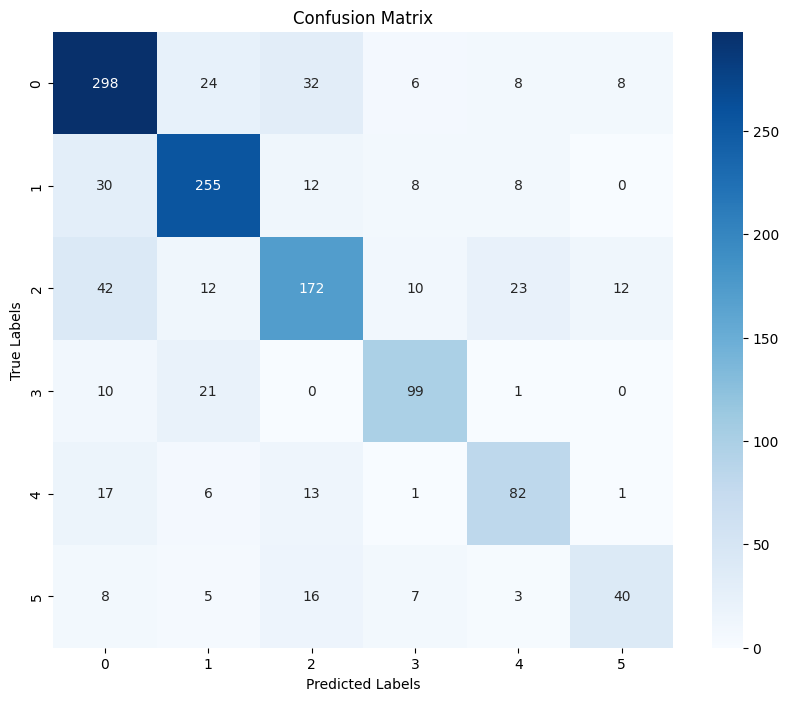

In [25]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def ensemble_inference(models, val_dl, device, num_classes):
    all_predictions = []
    all_labels = []
    
    # Initialize confusion matrix accumulators for each class
    TP = np.zeros(num_classes, dtype=int)
    TN = np.zeros(num_classes, dtype=int)
    FP = np.zeros(num_classes, dtype=int)
    FN = np.zeros(num_classes, dtype=int)
    
    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Collect predictions from each model
            model_predictions = []
            for model in models:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                model_predictions.append(predictions)

            # Majority voting or random selection if there is a tie
            model_predictions = torch.stack(model_predictions)
            final_predictions, _ = torch.mode(model_predictions, dim=0)
            for i in range(final_predictions.size(0)):
                if (model_predictions[:, i] == final_predictions[i]).sum() < 2:  # No majority
                    final_predictions[i] = model_predictions[np.random.randint(0, 3), i]

            all_predictions.extend(final_predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    # Calculate TP, TN, FP, FN for each class
    cm = confusion_matrix(all_labels, all_predictions, labels=range(num_classes))
    for i in range(num_classes):
        TP[i] = cm[i, i]
        TN[i] = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        FP[i] = np.sum(cm[:, i]) - cm[i, i]
        FN[i] = np.sum(cm[i, :]) - cm[i, i]
    
    # Print metrics
    print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
    print(f'TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}')
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assume models m1, m2, and m3 are defined and trained, and num_classes is known
# Run ensemble inference on trained models with the validation set
ensemble_inference([myModel_VGG, myModel_DN, myModel_RN], val_dl, device, 6)


Accuracy: 0.74, F1 Score: 0.74


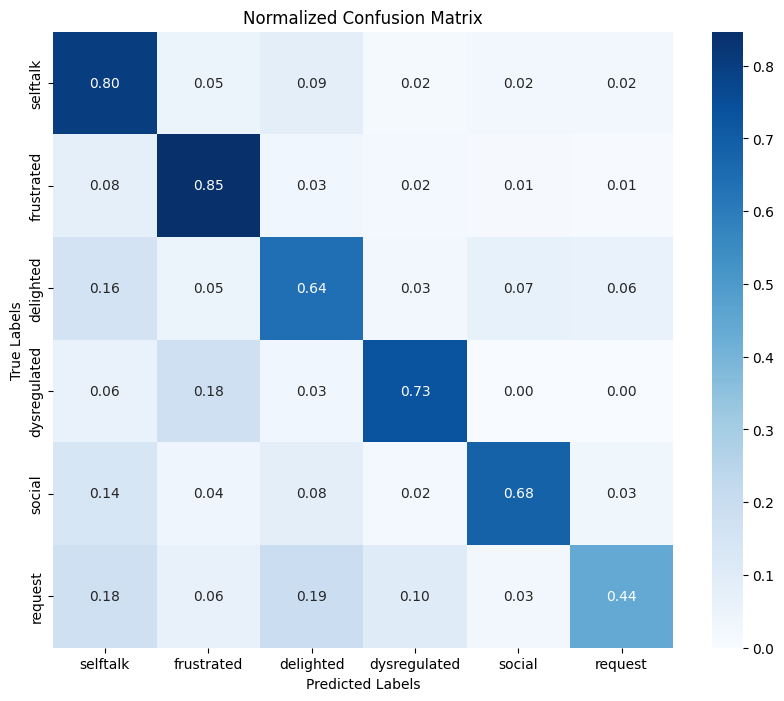

In [26]:
# Normalized Confusion Matrix
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def ensemble_inference(models, val_dl, device, class_names):
    all_predictions = []
    all_labels = []
    
    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Collect predictions from each model
            model_predictions = []
            for model in models:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                model_predictions.append(predictions)

            # Majority voting or random selection if there is a tie
            model_predictions = torch.stack(model_predictions)
            final_predictions, _ = torch.mode(model_predictions, dim=0)
            for i in range(final_predictions.size(0)):
                if (model_predictions[:, i] == final_predictions[i]).sum() < 2:  # No majority
                    final_predictions[i] = model_predictions[np.random.randint(0, 3), i]

            all_predictions.extend(final_predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    # Compute and normalize the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, normalize='true')

    # Print metrics
    print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()

ensemble_inference([myModel_VGG, myModel_DN, myModel_RN], val_dl, device, ['selftalk', 'frustrated', 'delighted', 'dysregulated', 'social', 'request'])

# Individual Inferences

In [27]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

def inference(model, val_dl):
    all_predictions = []
    all_labels = []
    
    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    f1 = f1_score(all_labels, all_predictions, average='weighted')
        
    print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')

In [28]:
inference(myModel_VGG, val_dl)

Accuracy: 0.71, F1 Score: 0.71


In [29]:
inference(myModel_DN, val_dl)

Accuracy: 0.68, F1 Score: 0.68


In [30]:
inference(myModel_RN, val_dl)

Accuracy: 0.71, F1 Score: 0.70
